<a href="https://colab.research.google.com/github/swaraj0009/AI_Models/blob/master/TFT/notebooks/4_ttf_resource_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Drive Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install Libraries

In [2]:
# ⚡ Quick Setup - Run after runtime reset (CPU/GPU Switch)
# Installs essential packages silently to save output clutter

!pip install dask pytz torch pytorch-forecasting pytorch-lightning \
    rich colorama matplotlib seaborn pandas numpy tensorboard \
    'lightning[extra]' pyarrow fastparquet --quiet > /dev/null

print("\033[92m✅ All required packages installed successfully.\033[0m")

✅ All required packages installed successfully.


## Import Libraries

In [3]:
# Standard Library
import os
import datetime
import glob
import json
import shutil
import math
import pytz
from concurrent.futures import ThreadPoolExecutor

# Third-Party Libraries
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

# PyTorch Lightning
# from datetime import datetime
import pytorch_forecasting
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# PyTorch Forecasting
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE

ist = pytz.timezone('Asia/Kolkata')
now_ist = datetime.datetime.now(ist)
timestamp = now_ist.strftime("%Y%m%d-%H%M%S")
print(f"All Libraries are loaded : {timestamp}")

All Libraries are loaded : 20250706-215111


## User Configurable Parameters

In [5]:

# Data path & VM selection
parquet_path = "/content/drive/MyDrive/datasets/processed/FeatureEng_full_streak.parquet"

# e.g., 50, 100, 250 etc.
num_vms_to_load = 200

# Model training parameters
train_config = {
    # 🎯 Prediction Targets
    "targets": [
        "cpu_utilization_ratio",
        "memory_utilization_ratio",
        "disk_total_throughput",
        "network_total_throughput"
    ],

    # 📅 Known time-dependent features (known at prediction time)
    "time_varying_known_reals": [
        "time_idx",
        "hour", "day", "dayofweek", "month", "is_weekend",
        "hour_sin", "hour_cos",
        "dayofweek_sin", "dayofweek_cos",
        "month_sin", "month_cos"
    ],

    # 📈 Features only known up to current timestep (future unknown)
    "time_varying_unknown_reals": [
        "cpu_util_prev", "cpu_util_diff",
        "memory_util_prev", "memory_util_diff",
        "network_total_prev", "network_total_diff",
        "disk_write_prev", "disk_write_diff",
        "disk_rolling_mean", "network_rolling_mean"
    ],

    # 🔐 Grouping feature
    "group_ids": ["vm_id"],

    # 🧠 Sequence lengths (adjust based on resources)
    "max_encoder_length": 2016,      # input length
    "max_prediction_length": 96,     # forecast horizon

    # ⚙️ Model Hyperparameters (tune later)
    "hidden_size": 16,
    "dropout": 0.2,
    "learning_rate": 0.001,
    "batch_size": 4,
    "num_workers": 2,

    # 🛑 Early stopping
    "early_stopping_patience": 5,
    "epochs": 10,

    # 🧮 Loss function
    "loss_fn": RMSE(),

    # 💾 Output paths
    "output_base_dir": "/content/drive/MyDrive/output",
    "log_dir": "/content/drive/MyDrive/output/logs"
}

# VM count for folder naming (update if needed)
vm_count = f"{num_vms_to_load}VMs"

In [7]:
df5 = pd.read_parquet(parquet_path)

print(f"✅ Loaded data shape: {df5.shape}")
print(f"🔢 Unique VMs: {df5['vm_id'].nunique()}")

✅ Loaded data shape: (6487138, 38)
🔢 Unique VMs: 751


In [8]:
# Group by VM and count how many time steps each VM has
vm_streaks = df5.groupby("vm_id").agg(
    total_points=("time_idx", "count"),
    max_time_idx=("time_idx", "max")
).reset_index()

# Sort by total_points (or max_time_idx) descending
top_200_vms = vm_streaks.sort_values(by="total_points", ascending=False).head(200)["vm_id"]

print(f"✅ Selected top 200 VMs with longest data streaks.")

✅ Selected top 200 VMs with longest data streaks.


## VM Configure

In [9]:
# Filter original DataFrame for these 200 VMs
df6 = df5[df5["vm_id"].isin(top_200_vms)].copy()
print(f"✅ Filtered data shape (top 200 VMs): {df6.shape}")

✅ Filtered data shape (top 200 VMs): (1727600, 38)


In [11]:
print(f"🎯 VMs in final dataset: {df6['vm_id'].nunique()}")  # Should be 200

🎯 VMs in final dataset: 200


## Columns Filter

In [15]:
# ✅ Drop unused columns based on train_config
columns_to_keep = (
    train_config["time_varying_known_reals"]
    + train_config["time_varying_unknown_reals"]
    + train_config["targets"]
    + train_config["group_ids"]
    + ['time_idx', 'timestamp']
)

# 🔁 Remove duplicates in case of overlaps
columns_to_keep = list(set(columns_to_keep))

# 📉 Filter DataFrame
df6 = df6[columns_to_keep]

print(f"✅ Columns after filtering: {len(df6.columns)}")

# 🧼 Optimize category column
if "vm_id" in df6.columns:
    df6["vm_id"] = df6["vm_id"].astype("category")
    df6["vm_id"] = df6["vm_id"].cat.remove_unused_categories()

print(f"\033[94mℹ️ Clean DataFrame → Columns: {len(df6.columns)} | Shape: {df6.shape}\033[0m")

✅ Columns after filtering: 28
ℹ️ Clean DataFrame → Columns: 28 | Shape: (1727600, 28)


## 70:30 Split Logic with Reset Index

In [18]:
train_ratio = 0.8

train_df_list = []
val_df_list = []

for vm_id, group in df6.groupby("vm_id",observed=False):
    group = group.sort_values("time_idx")
    split_idx = int(len(group) * train_ratio)

    train_df_list.append(group.iloc[:split_idx])
    val_df_list.append(group.iloc[split_idx:])

# Combine all
train_df = pd.concat(train_df_list).reset_index(drop=True)
val_df = pd.concat(val_df_list).reset_index(drop=True)

print(f"✅ Train shape: {train_df.shape}")
print(f"✅ Val shape: {val_df.shape}")

✅ Train shape: (1382000, 28)
✅ Val shape: (345600, 28)


## Pre validation check for split for Encoder & prediction

In [ ]:
# ---- Evaluation of time window sufficiency ----

max_encoder_length = train_config["max_encoder_length"]
max_prediction_length = train_config["max_prediction_length"]

# How many unique time_idx values in each split?
train_time_steps = train_df['time_idx'].nunique()
val_time_steps = val_df['time_idx'].nunique()

# Required steps
required_train_steps = max_encoder_length + max_prediction_length
required_val_steps = max_prediction_length
print("\n📊 Check: Config\n")

print(f"🟩 Max Encoder Length: {max_encoder_length}")
print(f"🟨 Max Prediction Length: {max_prediction_length}")
print(f"🟩 Both Combined: {required_train_steps}")

print("\n📊 Check: Does the split satisfy the window requirements?\n")

print(f"🟩 Total Row Length: {max_time_idx}")
print(f"🟩 Train Time Steps: {train_time_steps} (Required: ≥ {required_train_steps})")
print(f"🟨 Val Time Steps  : {val_time_steps} (Required: ≥ {required_val_steps})")

if train_time_steps >= required_train_steps:
    print("✅ Training window satisfies requirement.")
else:
    print("❌ Training window too short.")

if val_time_steps >= required_val_steps:
    print("✅ Validation window satisfies requirement.")
else:
    print("❌ Validation window too short.")


# Training needs: max_encoder_length + max_prediction_length
# Validation needs: max_prediction_length


📊 Check: Config

🟩 Max Encoder Length: 2016
🟨 Max Prediction Length: 2016
🟩 Both Combined: 4032

📊 Check: Does the split satisfy the window requirements?

🟩 Total Row Length: 8639
🟩 Train Time Steps: 6047 (Required: ≥ 4032)
🟨 Val Time Steps  : 2592 (Required: ≥ 2016)
✅ Training window satisfies requirement.
✅ Validation window satisfies requirement.


## Variable summary before Modeling


📊 VM Time Index Analysis:
- Total VMs              : 200
- Min steps per VM       : 1105
- Max steps per VM       : 8639
- Required per VM        : 4032
- ✅ Valid VMs            : 196
- ❌ Invalid VMs          : 4
- % Valid VMs            : 98.00%


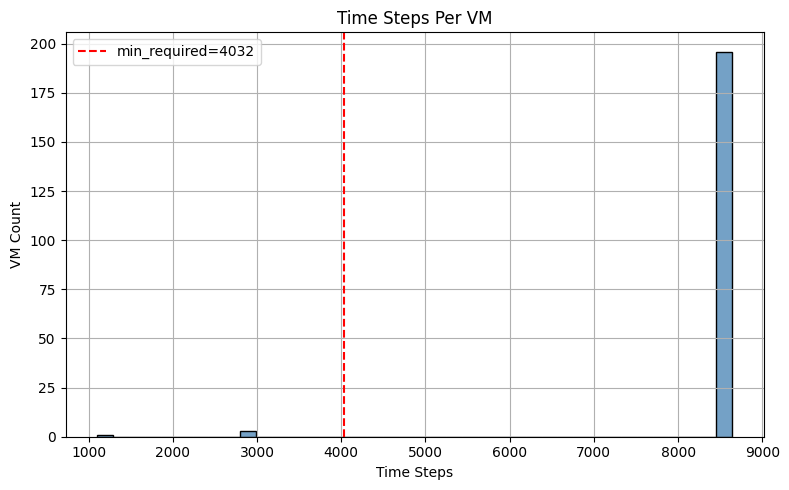

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Step 1: Count time_idx per VM
vm_time_lengths = tft_df.groupby("vm_id",observed=False)["time_idx"].nunique().sort_values()

# ✅ Step 2: Identify valid VMs
valid_vm_ids = vm_time_lengths[vm_time_lengths >= required_train_steps].index
invalid_vm_ids = vm_time_lengths[vm_time_lengths < required_train_steps].index

# ✅ Step 3: Report summary
print("\n📊 VM Time Index Analysis:")
print(f"- Total VMs              : {len(vm_time_lengths):,}")
print(f"- Min steps per VM       : {vm_time_lengths.min()}")
print(f"- Max steps per VM       : {vm_time_lengths.max()}")
print(f"- Required per VM        : {required_train_steps}")
print(f"- ✅ Valid VMs            : {len(valid_vm_ids):,}")
print(f"- ❌ Invalid VMs          : {len(invalid_vm_ids):,}")
print(f"- % Valid VMs            : {100 * len(valid_vm_ids) / len(vm_time_lengths):.2f}%")


# ✅ Step 4 (Optional): Filter invalid VMs
tft_df = tft_df[tft_df["vm_id"].isin(valid_vm_ids)]

# ✅ Step 5 (Optional): Histogram
plt.figure(figsize=(8, 5))
sns.histplot(vm_time_lengths, bins=40, kde=False, color="steelblue")
plt.axvline(required_train_steps, color="red", linestyle="--", label=f"min_required={required_train_steps}")
plt.title("Time Steps Per VM")
plt.xlabel("Time Steps")
plt.ylabel("VM Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Per VM check

In [ ]:
# Ensure time_idx is integer and sorted
val_df['time_idx'] = val_df['time_idx'].astype(int)
val_df = val_df.sort_values(["vm_id", "time_idx"]).reset_index(drop=True)

# Filter VMs that have enough data for validation
valid_val_vms = val_df.groupby("vm_id").filter(lambda x: x['time_idx'].nunique() >= max_prediction_length)
invalid_vms = val_df['vm_id'].nunique() - valid_val_vms['vm_id'].nunique()

print(f"✅ Valid VMs in val_df: {valid_val_vms['vm_id'].nunique()}")
print(f"⚠️  Skipped VMs in val_df due to insufficient time_idx: {invalid_vms}")

val_df = valid_val_vms.reset_index(drop=True)

✅ Valid VMs in val_df: 196
⚠️  Skipped VMs in val_df due to insufficient time_idx: 0


## Dataset and dataloaders ready

In [ ]:
# Fill missing values in relevant columns
# fill_cols = ['disk_rolling_mean', 'network_rolling_mean', 'disk_rolling_std', 'network_rolling_std']
# for col in fill_cols:
#     if col in train_df.columns:
#         train_df[col] = train_df[col].fillna(0)
#     if col in val_df.columns:
#         val_df[col] = val_df[col].fillna(0)

# Prepare TimeSeriesDataSet for training portion (70%)

dataset = TimeSeriesDataSet(
    train_df,
    time_idx='time_idx',
    target=train_config["targets"][0],  # 'cpu_utilization_ratio' here
    group_ids=train_config["group_ids"],
    max_encoder_length=train_config["max_encoder_length"],
    max_prediction_length=train_config["max_prediction_length"],
    time_varying_known_reals=train_config["time_varying_known_reals"],
    time_varying_unknown_reals=train_config["time_varying_unknown_reals"],
    target_normalizer=GroupNormalizer(groups=train_config["group_ids"]),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# Validation dataset for prediction (no randomization, full data)
# ✅ "TimeSeriesDataSet applies sliding window logic on the training data,
# using the full configuration like past steps, future steps, groups, and prepares the dataset accordingly."

# Filter val_df to include only VMs with sufficient data for prediction
required_val_steps = train_config["max_prediction_length"]
valid_val_vms_filtered = val_df.groupby("vm_id").filter(lambda x: x['time_idx'].nunique() >= required_val_steps)

# Reset index before creating the validation dataset
val_df_for_dataset = valid_val_vms_filtered.reset_index(drop=True)

val_dataset = TimeSeriesDataSet.from_dataset(
    dataset,
    val_df_for_dataset,
    predict=True,
    stop_randomization=True
)


# Create dataloaders
# performs Batching, Padding, Time-aware slicing for forecasting

train_dataloader = dataset.to_dataloader(
    train=True,
    batch_size=train_config["batch_size"],
    num_workers=train_config["num_workers"]
)

val_dataloader = val_dataset.to_dataloader(
    train=False,
    batch_size=train_config["batch_size"],
    num_workers=train_config["num_workers"]
)


print(f"✅ Dataset and dataloaders ready. Train batches: {len(train_dataloader)}, Val batches: {len(val_dataloader)}")

AssertionError: filters should not remove entries all entries - check encoder/decoder lengths and lags

## Output & Log Folder Creation

In [ ]:
# Setup output and log folders based on run config

import pytz
import datetime

ist = pytz.timezone('Asia/Kolkata')
now_ist = datetime.datetime.now(ist)
timestamp = now_ist.strftime("%Y%m%d-%H%M%S")

def get_run_folder_name(train_config, vm_count):
    target = "cpu"
    past = f"past{train_config['max_encoder_length']}"
    fut = f"fut{train_config['max_prediction_length']}"
    batch = f"bs{train_config['batch_size']}"
    lr = f"lr{train_config['learning_rate']:.0e}".replace('+0', '')
    hid = f"hid{train_config['hidden_size']}"

    return f"{target}_{vm_count}_{past}_{fut}_{batch}_{lr}_{hid}_{timestamp}"

folder_name = get_run_folder_name(train_config, vm_count)

train_config["output_base_dir"] = os.path.join(train_config["output_base_dir"], folder_name)
train_config["log_dir"] = os.path.join(train_config["log_dir"], folder_name)

os.makedirs(train_config["output_base_dir"], exist_ok=True)
os.makedirs(train_config["log_dir"], exist_ok=True)

print("Output directory:", train_config["output_base_dir"])
print("Log directory:", train_config["log_dir"])

# Now you can proceed to model training using `tft_df` and `train_config` as usual.

## Logging & Callbacks

In [ ]:
# Logging & Callbacks
from pytorch_lightning.callbacks import EarlyStopping

for target in train_config["targets"]:
    print(f"\n🔁 Training for target: {target}")

    run_dir = os.path.join(train_config["output_base_dir"], f"{target}_run_{timestamp}")
    os.makedirs(run_dir, exist_ok=True)

    # Save Raw cleaned DF for inspection (TFT input format)
    tft_df.to_csv(f"{run_dir}/tft_df.csv", index=False)

    # Save structured TimeSeriesDataset (structure, scalers, etc.)
    dataset.save(f"{run_dir}/tft_df_metadata")  # <-- .save stores dataset metadata

    # Save metadata for mapping forecasts (VM, time)
    meta_cols = ['vm_id', 'timestamp', 'time_idx']

    if all(col in val_df.columns for col in meta_cols):
        meta_df = val_df[meta_cols].reset_index(drop=True)
        meta_df.to_csv(f"{run_dir}/forecast_metadata.csv", index=False)
        print(f"✅ Metadata saved to: {run_dir}/forecast_metadata.csv")
    else:
        print(f"⚠️ Skipping metadata save — columns not found: {meta_cols}")

    # Setup logging & checkpointing
    logger = CSVLogger(save_dir=train_config["log_dir"], name=f"{target}_log")

    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath=run_dir,
        filename="tft-{epoch:02d}-{val_loss:.2f}",
        save_top_k=1,
        save_last=True,
        mode="min"
    )

    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=train_config["early_stopping_patience"],
        mode="min"
    )

## Model, Lightning, Trainer

In [ ]:
import pytorch_lightning as pl

class TFTLightningModule(pl.LightningModule):
    def __init__(self, tft_model: TemporalFusionTransformer, learning_rate: float, loss_fn: torch.nn.Module):
        super().__init__()
        self.tft_model = tft_model
        self.learning_rate = learning_rate
        self.loss_fn = loss_fn

    def forward(self, x):
        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat.prediction, y) # Extract prediction from output
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat.prediction, y) # Extract prediction from output
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# Create the TFT model
tft_model = TemporalFusionTransformer.from_dataset(
    dataset,
    learning_rate=train_config["learning_rate"],
    hidden_size=train_config["hidden_size"],
    dropout=train_config["dropout"],
    loss=train_config["loss_fn"],
    log_interval=10,
    reduce_on_plateau_patience=4
)

# Wrap the TFT model in a LightningModule
model = TFTLightningModule(
    tft_model=tft_model,
    learning_rate=train_config["learning_rate"],
    loss_fn=train_config["loss_fn"]
)

# Setup Trainer
if torch.cuda.is_available():
    accelerator = "gpu"
    devices = 1
else:
    accelerator = "cpu"
    devices = 1

trainer = Trainer(
    max_epochs=train_config["epochs"],
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping],
    enable_checkpointing=True
)

# Fit the model
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

# Actual vs Prediction Graphs

In [ ]:
# 🔮 Step 1: Make raw predictions on validation set
prediction_output = model.tft_model.predict(
    val_dataloader, mode='raw', return_x=True
)

# ✅ Step 2: Extract input and output
x = prediction_output.x
predictions = prediction_output.output

# ✅ Step 3: Extract forecast values as numpy array (for CSV export)
forecast = predictions.prediction[0].detach().cpu().numpy()

# ✅ Step 4: Plot forecast using built-in TFT visualization
fig = model.tft_model.plot_prediction(
    x, predictions, idx=0, show_future_observed=True
)
plt.title(f"Prediction Plot for {target}")

# ✅ Reduce legend size and move it neatly outside
plt.legend(
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize='small',      # You can try 'small', 'x-small', numeric values like 8
    frameon=True,          # Adds box around legend for clarity
)

plt.tight_layout()
plt.show()

# ✅ Step 5: Save the plot as PNG
plt.savefig(f"{run_dir}/plot.png", bbox_inches='tight')  # Ensure nothing gets cut off
plt.close()
print(f"✅ Prediction plot saved at: {run_dir}/plot.png")

# ✅ Step 6: Save forecast to CSV
pd.DataFrame(forecast, columns=[f'{target}_forecast']).to_csv(
    f"{run_dir}/predictions.csv", index=False
)
print(f"✅ Forecast values saved to: {run_dir}/predictions.csv")

## Spike Detection & Save Metadata

In [ ]:
spikes = forecast > np.percentile(forecast, 95)

# Save run notes and spike count
with open(f"{run_dir}/notes.txt", "w") as f:
    f.write(f"Target: {target}\n")
    f.write(f"Spikes > 95th percentile: {int(spikes.sum())}\n")
    f.write("Review plot.png and predictions.csv for further insights.\n")

# 💾 Save training config for reproducibility
# Create a serializable version of train_config
serializable_train_config = train_config.copy()
# Replace the non-serializable loss_fn object with its name
serializable_train_config["loss_fn"] = serializable_train_config["loss_fn"].__class__.__name__

with open(f"{run_dir}/modelconfig.json", "w") as f:
    json.dump(serializable_train_config, f, indent=2)

print(f"✅ Run complete. Outputs saved at: {run_dir}")

In [ ]:
forecast_path = os.path.join(run_dir, "predictions.csv")
print(f"✅ Forecast values saved to: {forecast_path}")

In [ ]:
# # Command to inspect .ckpt

# ckpt = torch.load("path/to/tft-epoch=01-val_loss=0.04.ckpt", map_location=torch.device('cpu'))
# print(ckpt.keys())

In [ ]:
# print(ckpt["epoch"])             # Epoch number
# print(ckpt["global_step"])       # Total steps
# print(ckpt["hyper_parameters"])  # Saved hyperparameters

In [ ]:
# Diagnose the AssertionError in val_dataset creation

required_prediction_length = train_config["max_prediction_length"]
print(f"Checking validation data for VMs with less than {required_prediction_length} consecutive time steps.")

invalid_vms_for_prediction = []

for vm_id, group_df in val_df_for_dataset.groupby('vm_id', observed=False):
    # Check for continuous time indices
    time_indices = group_df['time_idx'].sort_values().tolist()
    if not time_indices:
        invalid_vms_for_prediction.append(vm_id)
        print(f"  - VM {vm_id}: No time indices found.")
        continue

    # Check if there is any sequence of length required_prediction_length
    # A simple check is to see if the total number of time steps is enough
    # for at least one sequence. More robust check would involve looking for gaps.
    max_possible_sequences = max(0, time_indices[-1] - time_indices[0] - required_prediction_length + 2)


    if group_df['time_idx'].nunique() < required_prediction_length:
         invalid_vms_for_prediction.append(vm_id)
         print(f"  - VM {vm_id}: Total unique time steps ({group_df['time_idx'].nunique()}) is less than required prediction length ({required_prediction_length}).")

    # More thorough check for gaps - simplified approach
    # Check if the difference between consecutive time_idx is always 1
    if not all(diff == 1 for diff in np.diff(time_indices)):
         # This VM has gaps. Let's check if there's *at least one* valid sequence possible
         # A valid sequence needs required_prediction_length consecutive time_idx values.
         # This is a simplified check and might not catch all edge cases with multiple small gaps.
         has_valid_sequence = False
         if len(time_indices) >= required_prediction_length:
             for i in range(len(time_indices) - required_prediction_length + 1):
                 if all(time_indices[i+j] == time_indices[i] + j for j in range(required_prediction_length)):
                     has_valid_sequence = True
                     break
         if not has_valid_sequence:
              invalid_vms_for_prediction.append(vm_id)
              print(f"  - VM {vm_id}: Has gaps or not enough consecutive time steps for prediction sequences.")


# Remove duplicate VM IDs if any were added multiple times
invalid_vms_for_prediction = list(set(invalid_vms_for_prediction))

if invalid_vms_for_prediction:
    print(f"\n⚠️ Found {len(invalid_vms_for_prediction)} VMs causing issues for validation dataset creation:")
    print(invalid_vms_for_prediction)
    print("\nThese VMs likely do not have a continuous sequence of time indices of length equal to or greater than the max_prediction_length in the validation set.")
else:
    print("\n✅ All VMs in val_df_for_dataset appear to have enough consecutive time steps for prediction sequences.")

Checking validation data for VMs with less than 2016 consecutive time steps.
  - VM 94: No time indices found.
  - VM 97: No time indices found.
  - VM 103: No time indices found.
  - VM 104: No time indices found.
  - VM 111: Has gaps or not enough consecutive time steps for prediction sequences.
  - VM 116: Has gaps or not enough consecutive time steps for prediction sequences.
  - VM 117: Has gaps or not enough consecutive time steps for prediction sequences.
  - VM 907: Has gaps or not enough consecutive time steps for prediction sequences.
  - VM 910: Has gaps or not enough consecutive time steps for prediction sequences.
  - VM 911: Has gaps or not enough consecutive time steps for prediction sequences.
  - VM 912: Has gaps or not enough consecutive time steps for prediction sequences.
  - VM 914: Has gaps or not enough consecutive time steps for prediction sequences.
  - VM 915: Has gaps or not enough consecutive time steps for prediction sequences.
  - VM 917: Has gaps or not e